# Analiza obrazów

Dyskretna transformata Fouriera umożliwa przekształcenie obrazu z domeny czasu do domeny częstotliwościowej. Ze względu na charakterystykę DFT przekształcane obrazy powinny na brzegach mieć nmożliwie iskie wartości, aby uniknąć powstawania artefaktów - zwykle oznacza to konieczność odwrócenia kolorów.

In [1]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from tqdm import tqdm
from numpy.fft import fft2, ifft2
from textdistance.algorithms.edit_based import levenshtein

## Wizualizacja transformaty Fouriera

Poniższe funkcje słuzą do przygotowania danych wejściowych i wizualizacji obrazu wraz z wynikiem jego transformacji do domeny częstotliwościowej.

In [2]:
def load_text(name):
    "loads image and returns it in greyscale with inverted colors"
    img = Image.open(name).convert('L')
    return np.array(ImageOps.invert(img))

def fourier_components(img):
    "splits imaginary array into real components (length, angle)"
    fourier = fft2(img)
    mod = np.absolute(fourier)
    angle = np.angle(fourier)
    return mod, angle

def visualise_dft(img, font_size=20):
    mod, angle = fourier_components(img)
    big_num_idx = mod.flatten().argsort()[int((mod.shape[0]*mod.shape[1])*0.99)]
    new_maximum = mod.flatten()[big_num_idx]
    mod[mod>new_maximum] = new_maximum
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7,10))
    for ax in axes: ax.axis("off")
    axes[0].imshow(img)
    axes[0].set_title("original image", fontdict={"fontsize": font_size})
    pos = axes[1].imshow(mod)
    fig.colorbar(pos, ax=axes[1])
    axes[1].set_title("modulus of coefficients", fontdict={"fontsize": font_size})
    pos = axes[2].imshow(angle)
    fig.colorbar(pos, ax=axes[2])
    axes[2].set_title("phase of coefficients", fontdict={"fontsize": font_size})
    plt.show()

Poniżej znajduje się wizualizacja współczynników Fouriera (wartości modułu i fazy) dla obrazu z tekstem. Jako, że część z wartości modułu silnie odstaje to na potrzeby wizualizacji są one pomniejszone (wszystkie wartości stanowiące górny 1% są zmienione na najniższą wartość z tego jednego procenta) - podejście takie pozwala na uniknięcie sytuacji w której wizualizacja jest jednorodnym obrazem.

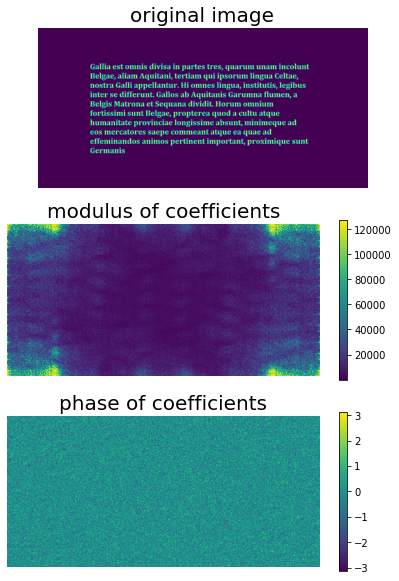

In [3]:
galia = load_text("galia.png").astype(np.float64)
template_e = load_text("galia_e.png").astype(np.float64)
h, w = galia.shape
visualise_dft(galia)

## Wizualizacja na sztucznym obrazie

Poniższa wizualizacja także pokazuje wartości modułu i fazy, lecz na prostszym, syntetycznym obrazie. Ma ona na celu zapewnienie prostszego do analizy przykładu pozbawionego szumu.

In [4]:
from matplotlib.widgets import Slider

In [5]:
%matplotlib notebook

<IPython.core.display.Javascript object>


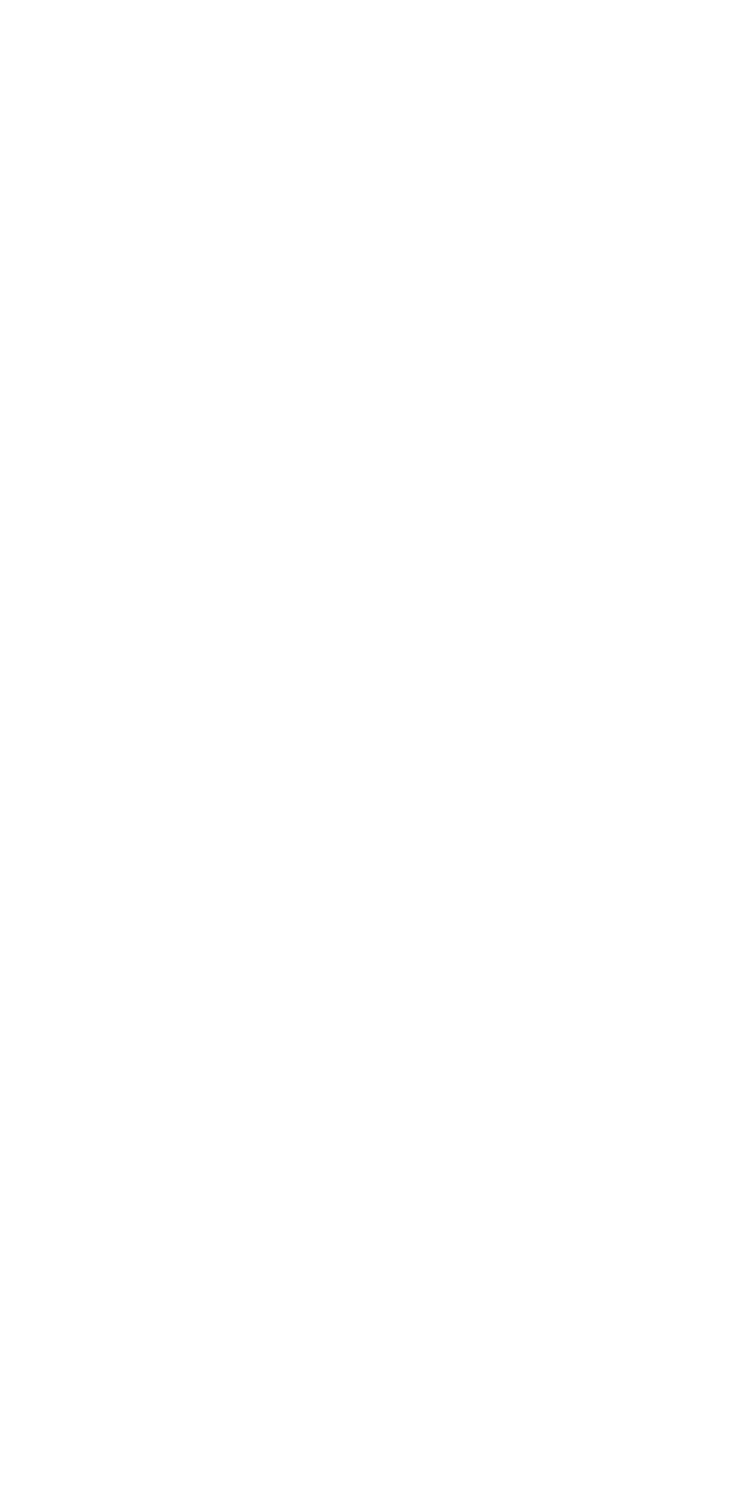

In [6]:
TWOPI = 2*np.pi
font_size = 10
freq_x = 1
freq_y = 0

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5,10))
axes[0].set_title("original image", fontdict={"fontsize": font_size})
axes[1].set_title("modulus of coefficients", fontdict={"fontsize": font_size})
axes[2].set_title("phase of coefficients", fontdict={"fontsize": font_size})
for ax in axes: ax.axis('off')
x = np.arange(0.0, TWOPI, 0.05)
y = np.arange(0.0, TWOPI, 0.05)
spacex,spacey = np.meshgrid(x, x)
space = spacex*freq_x+spacey*freq_y

img = np.sin(space)
img_obj = []
img_obj.append(axes[0].imshow(img))
mod, angle = fourier_components(img)
img_obj.append(axes[1].imshow(mod))
img_obj.append(axes[2].imshow(angle))

locx = plt.axes([0.15, 0.01, 0.7, 0.03])
locy = plt.axes([0.15, 0.05, 0.7, 0.03])
x_slider = Slider(locx, 'freq_x', 0, 30, valinit=freq_x)
y_slider = Slider(locy, 'freq_y', 0, 30, valinit=freq_y)

def update_x(val):
    global freq_x
    freq_x = val
    space[:,:] = spacex*freq_x + spacey*freq_y
    img = np.sin(space)
    mod, angle = fourier_components(img)
    img_obj[0].set_data(img)
    img_obj[1].set_data(mod)
    img_obj[2].set_data(angle)
    fig.canvas.draw_idle()
    
    
def update_y(val):
    global freq_y
    freq_y = val
    space = spacex*freq_x + spacey*freq_y
    img = np.sin(space)
    mod, angle = fourier_components(img)
    img_obj[0].set_data(img)
    img_obj[1].set_data(mod)
    img_obj[2].set_data(angle)
    fig.canvas.draw_idle()

x_slider.on_changed(update_x)
y_slider.on_changed(update_y)

plt.show()

In [7]:
%matplotlib inline

## Obliczanie korelacji

Twierdzenie o splocie:  

$x\star y = DFT^{-1}[DFT\{x\}*DFT\{y\}]$   

Pozwala na szybkie obliczenie splotu ($x\star y$) przy pomocy dyskretynej transformaty Fouriera. Dla obrazu o rozmiarach NxN i wzorca o rozmiarach TxT złożności obliczeniowe wynoszą:     

- $O(N^2W^2)$ dla obliczania bezpośrednio  
- $O(N^2)$ dla obliczania z wykorzystanie DFT  

In [8]:
def slow_corr(img, template):
    "calculates correlation using classical approach (sliding template)"
    C = np.zeros((h,w), dtype=np.float64)
    for i in range(h - 13):
        for j in range(w - 13):
            C[i+12,j+12] = np.sum(img[i:i+13,j:j+13]*template[:,:])
    return C

C_slow = slow_corr(galia, template_e)

In [9]:
def corr(img, template):
    "calculates correlation using discrete fourier transform"
    h, w = img.shape
    return (ifft2(fft2(img)*fft2(np.rot90(template,2),[h,w]))).astype(np.float64)

C = corr(galia, template_e);

/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


Sprawdzenie czy wyniki uzyskane obydwoma sposobami rzeczywiście są identyczne pozwala na zweryfikowanie poprawności twierdzenia.

In [10]:
np.allclose(C, C_slow)

True

Na poniższych pomiarach widać, że zastosowanie DTF rzeczywiście powoduje znaczne przyspieszenie - na przykładowych danych aż 25-krotne

In [11]:
%%timeit
corr(galia, template_e);

/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


137 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%%timeit
slow_corr(galia, template_e)

4.17 s ± 392 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Wizualizacja korelacji

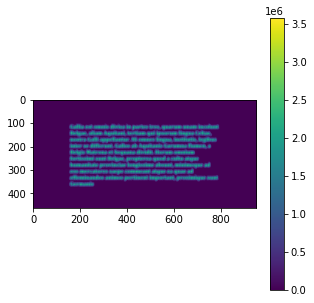

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(C)
plt.colorbar()
plt.show()

### Poszukiwanie maximów

Dokonujemy normalizacji korelacji tak, aby jej wartości leżały w przedziale \[0, 1\] celem ułatwienia poszukiwania maximów.

In [14]:
def normalise(x):
    m = np.min(x)
    return (x - m)/(np.max(x) - m)

C = normalise(C)

Funkcja `count_max(C, template, threshold)` zlicza i zaznacza wszystkie lokalne maxima w macierzy `C`. Aby maximum zostało zliczone dla współrzędnych i,j jego wartość musi być większa niż `threshold` oraz nie może być w jego otoczeniu (zdefiniowanym przez `template`) wartości większych niż C\[i,j\].

In [15]:
def count_max(C, template=(13,13), threshold=0.9, rectangle=True):
    "returns number of maxima & mask with their positions"
    h, w = template
    y, x = h//2, w//2
    count = 0
    maxima = np.zeros(shape=C.shape)
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            if C[i,j] > threshold:
                r = np.sum(C[i-y:i+y+1,j-x:j+x+1]>=C[i,j])
                if r==1:
                    if rectangle:
                        maxima[i-h:i+1,j-w:j+1] = 255
                    else:
                        maxima[i,j] = 255
                    count+=1
    return count, maxima

c, maxima = count_max(C, threshold=0.99)
print(c)

43


### Wizualizacja wyniku

Poniżej znajduje się wynik poszukiwania na obrazie z tekstem wystąpień litery 'e'. Każdy zaznaczony kwadrat oznacza, że w jego prawym dolnym rogu zostało wykryte maximum w obliczonej macierzy korelacji. Ilość znalezionych wystąpień litery została wypisana w tytule wykresu.

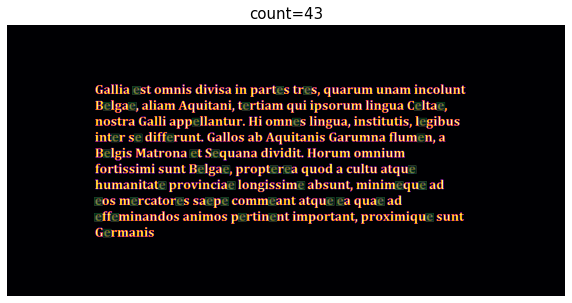

In [16]:
def show_max(background, maxima, alpha=0.6, cmap_back=None, cmap_max=None, title=""):
    plt.figure(figsize=(10,10))
    plt.imshow(background, cmap=cmap_back)
    mask = np.zeros(maxima.shape)
    mask[maxima != 0] = alpha
    plt.imshow(maxima, alpha=mask, cmap=cmap_max)
    plt.title(title, size=15)
    plt.axis('off')
    plt.show()
    
show_max(galia, maxima, cmap_back='inferno', cmap_max='Greens', title=f"count={c}")

### Analiza zdjęcia ławicy ryb

Znajdywanie ryb na zdjęciu przedstawiającym ławicę jest zdecydowanie trudniejsze niż poszukiwanie liter. Podstawową różnicą jest zmiana liczby wymiarów obrazu i wzorca - w tym przykładzie ze względu na występowanie kolorów są one 3-wymiarowe. Z tego powodu wartość korelacji będzie średnią z 3 koleracji wyliczonych dla odpowiednich kolorów.  
Koleracja od razu także zostaje znormalizowana do zakresu \[0, 1\].  
Jako, że zdjęcie ławicy nie posiada jednoznacznie wysokich wartości na swoich brzegach to jego kolory nie zostaną odwrócone.

In [17]:
school = np.array(Image.open("school.jpg")).astype(np.float64)
template_fish =  np.array(Image.open("fish1.png")).astype(np.float64)
h, w, _ = school.shape

In [18]:
C = [corr(img, temp).swapaxes(0,1) for img,temp in 
     zip(school.swapaxes(0,2),template_fish.swapaxes(0,2))] # calculationg correlation for each color
C = np.mean(C, axis=0) # mean of color-based correlations
C = normalise(C)

/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


#### Wizualizacja korelacji

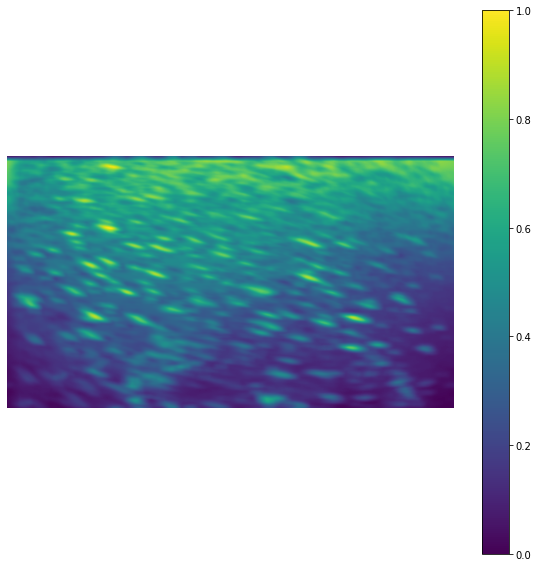

In [19]:
plt.figure(figsize=(7, 7))
plt.imshow(C)
plt.axis('off')
plt.colorbar()
plt.show()

#### Poszukiwanie odpowiedniej wartości progowej dla uznania maximum  


   
Maxima są wykrywane i zaznaczane tak samo jak dla obrazu z tekstem.

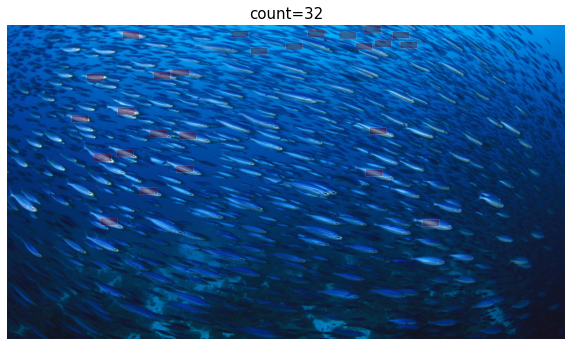

In [20]:
def show_example(C, threshold):
    c, maxima = count_max(C, template=template_fish.shape[:2],threshold=threshold)
    show_max(school.astype(np.uint8), maxima, alpha=0.4, cmap_max="Reds", title=f"count={c}")
    
show_example(C, threshold=0.8)

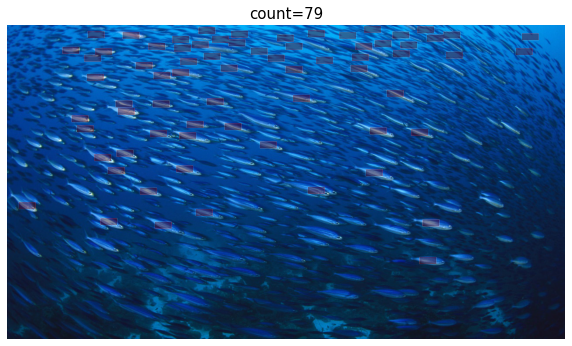

In [21]:
show_example(C, threshold=0.7)

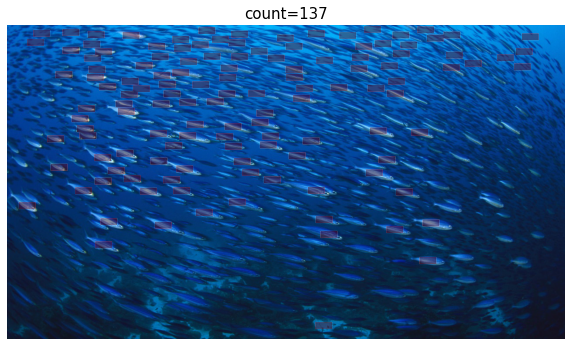

In [22]:
show_example(C, threshold=0.6)

### Wnioski

Zliczenie ryb ze zdjęcia przedstawionym sposobem jest zadaniem skrajnie trudnym. Dla dużych wartośći progu sporo ryb zostaje pominiętych, z kolei dla małych zliczone zostaje dużo przypadkowych miejsc, które nie powinny być wykryte przez wzorzec. Jeżeli uznamy tylko wystąpienia, które są wyraźnie pewne, to okaże się że zdjęcie zawiera tylko kilkanaście-kilkadziesiąt ryb.  

Problemy sprawiają:  
- różne kąty nachylenia ryb  
- zmienne oświetlenie  
- zmienna odległość od kamery, a co za tym idzie wielkość na zdjęciu  
- ryby mogą różnić się miedzy sobą kształtem lub kolorystyką  
  
  
Znajdywanie wzorca przy użyciu korelacji, wydaje się nadawać tylko do problemów w których możemy oczekiwać, że wzorzec jest niezmienny (lub minimalnie zmienny).

# OCR

Optyczny system rozpoznwania znaków (ang. OCR), będzie bazował na obliczaniu korelacji pomiędzy wzorcami poszukiwanych znaków i obrazem wejściowym. System zakłada, że na obrazie występuje tylko jedna czcionka, która jest znana z góry.  

Wszystkie obrazy od razu powstają z odwróconą kolorystyką, aby uniknąć artefaktów przy dft

In [23]:
from PIL import ImageFont
from PIL import ImageDraw 
import string
import lorem
from tqdm import tqdm

## Obliczanie korelacji

Przy systemie OCR zostanie zastosowany inny sposób normalizowania korelacji niż przy analizie obrazó. Uzyskane dla danego wzorca wartości korelacji będa dzielone przez `norm` - maksymalną wartość możliwą do uzyskania dla danego wzorca (dla wzorca 'p' o rozmiarach $n \times m$: `norm`$= \sum_{i=1}^n \sum_{j=1}^m p[i,j]^2$).   
Dzięki temu uzyskane wartości nie będą uzależnione od wartości maksymalnej, co pozwoli na porównywanie między sobą wartości korelacji otrzymanych dla różnych wzorców - wcześniejsze podejście sprawiłoby, że nawet niewystępujące w tekście litery posiadałyby w niektórych miejschach wartość korelacji (po znormalizowaniu) równą 1, co skutecznie uniemożliwia znalezienie najlepiej dopasowanego w danym miejscu wzorca.  

Za obliczenie i znormalizowanie korelacji odpowiada funkcja `norm_corr`. Można do niej przekazać obraz w domenie czasowej lub częstotliwościowej (co jest przydatne do zmiejszenia ilości potrzebnych obliczeń).

In [24]:
def norm_corr(template, img=None, img_fft=None):
    assert not (img is None and img_fft is None)
    if img is not None:
        h, w = img.shape
    else:
        h, w = img_fft.shape
    norm = np.sum(template**2)
    if img_fft is None:
        img_fft = fft2(img)
    return (ifft2(img_fft*fft2(np.rot90(template,2),[h,w]))).astype(np.float64) / norm

## Przygotowanie danych wejściowych

Funkcja `prepare_templates(font, angle=0, margin=5, use_interpunction)` służy do przygotowania wzorców znaków, które będą poszukiwane w obrazie. Wzorce są przygotowywane dla małych liter i cyfr oraz w zależności od ustawienia parametru `use_interpunction` także dla znaków interpunkcyjnych.

In [25]:
def prepare_templates(font, angle=0,  margin=5, use_interpunction=False):
    templates = []
    n = max(max(font.getsize('W')), max(font.getsize('Q')))
    characters = string.ascii_lowercase + "1234567890"
    if use_interpunction:
        characters += ",.!?"
    for letter in characters:
        letter_img = Image.fromarray(np.zeros((n+margin,n+margin)))
        draw = ImageDraw.Draw(letter_img)
        draw.text((margin, margin), letter, font=font, fill='#fff')
        letter_img = letter_img.rotate(angle, expand=True)
        template = np.array(letter_img)
        top, bot, left, right = 0, n+margin, 0, n+margin

        template = template[top:bot, left:right]
        templates.append((template, letter))
    return templates

font = ImageFont.truetype("/usr/share/fonts/truetype/freefont/FreeSerif.ttf", size=60)
templates = prepare_templates(font)

Krótki tekst na którym będą przeprowadzone początkowe testy:

In [26]:
original_text = """szerszen wpada do pokoju
dowiedz sie, ze szerszenie widza w podczerwieni
przesylacie sobie piosenki
123 456 789 0
ab, ac. dc? al!\n"""

Obraz z tekstem jest przygotowywany przez funkcję `make_image(text, angle, font)`, która wypisuje na obrazie zmienną `text` w czionce `font` oraz dokonuje jego obrotu o kąt `angle`

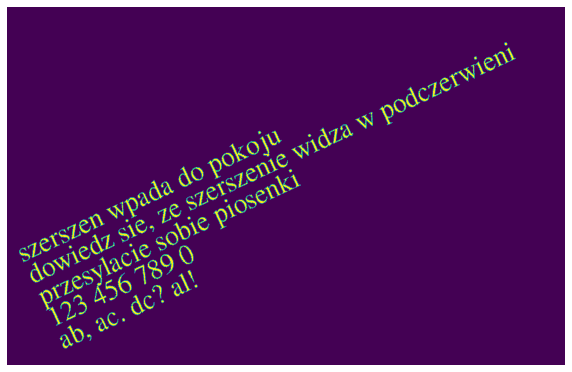

In [27]:
def make_image(text, angle, font, img_shape=(300,1200), text_start=(10,10)):
    img = Image.fromarray(np.zeros(img_shape))
    draw = ImageDraw.Draw(img)
    draw.text(text_start, text, font=font, fill='#fff')
    img = img.rotate(angle, expand=True)
    return np.array(img)


img = make_image(original_text, 25, font)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show();

Przed rozpoczęciem rozpoznawania znaków obraz najpierw musi zostać odwrócony o odpowiedni kąt tab, aby wszystkie linie przebiegały w poziomie. Funkcja `determine_angle` znajduje kąt o jaki tekst jest obrócony przez znalezienia takiego kąta, dla którego korelacja pomiędzy wzorcem (litera 'a') i obrazem będzie maksymalna. Sprawdzane są kąty od $-180^\circ$ do $180^\circ$, a ilość sprawdzonych kątów kontroluje zmienna `step`.

In [28]:
def determine_angle(img, font, step=5):
    best_angle = 0
    best_corr = 0
    n = max(max(font.getsize('W')), max(font.getsize('Q')))
    templates = []
    base_template = Image.fromarray(np.zeros((n,n)))
    draw = ImageDraw.Draw(base_template)
    draw.text((0, 0), 'a', font=font, fill='#fff')
    img_fft = fft2(img)
    
    for angle in tqdm(range(-180, 181, step),position=0):
        C = norm_corr(np.array(base_template.rotate(angle)), img_fft=img_fft)
        if np.max(C) > best_corr:
            best_corr = np.max(C)
            best_angle = angle
    return best_angle
    
angle = determine_angle(img, font, step=1)
print("roration angle =", angle)

  0%|          | 0/361 [00:00<?, ?it/s]/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 361/361 [00:31<00:00, 11.53it/s]

roration angle = 24


Znalezienie kąta obrotu pozwala na wypoziomowanie obrazu, służy do tego funkcja `unrotate`

  0%|          | 0/73 [00:00<?, ?it/s]/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 73/73 [00:06<00:00, 11.97it/s]


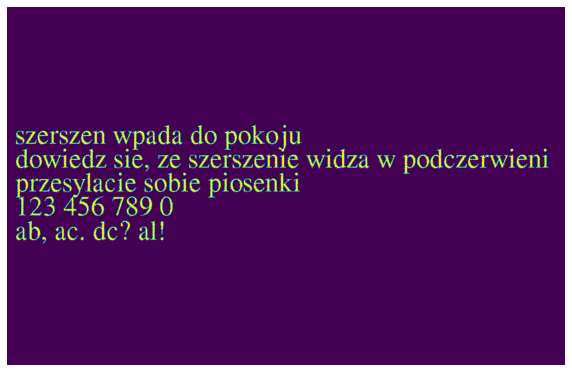

In [29]:
def unrotate(img, font):
    angle = determine_angle(img, font)
    img = np.array(Image.fromarray(img).rotate(-angle))
    return img

img = unrotate(img, font)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

## Właściwy algorytm

Przyjęte jest założenie, że zostaje zapewniony obraz z wypoziomowanym tekstem.  

Algorytm OCR działa w następujacy sposób:   
- dla każdego znaku:   
    - zostaje obliczona korelacja   
    - każde miejsce, gdzie korelacja przekracza wartość progową, zostaje uznane za wystąpienie znaku (chyba, że wcześniej został w tym samym miejscu znaleziony znak z wyższą korelacją)   
    - znaki zostają wpisane w miejscu ich wykrycia do macierzy (o rozmiarach takich jak wejściowy obraz)    
- następnie następuje przejście po każdym wierszu macierzy ze znakami:    
    - każdy napotkany znak zostaje dodany do wyjściowego tekstu   
    - jeżeli pomiędzy dwoma sąsiednimi znakami w danym wierszy występuje co najmniej `space_size` pustych miejsc to do tekstu wyjściowego zostaje dodany znak spacji   
    - jeżeli w danym wierszu występują jakiekolwiek litery to jako ostatni zostaje dodany znak nowej linii    

In [30]:
def ocr(img, templates, space_size=25, threshold=0.95):
    text_array = np.zeros(img.shape, dtype=np.character)
    shape = [i for i in img.shape]
    C_archive = np.zeros([len(templates)] + shape, dtype=np.float32)
    img_fft = fft2(img)
    for i, (template, letter) in tqdm(enumerate(templates), position=0):
        C = norm_corr(template, img_fft=img_fft)
        C_archive[i, :, :] = C[:, :]
        assert np.max(C) <= 1. + 1e-3, f"{letter} {np.max(C)}"
        c, maxima = count_max(C, rectangle=False, threshold=threshold)
        maxima_idx = maxima == 255
        overrited_idx = np.logical_and(text_array != b'', maxima)
        if np.any(overrited_idx):
            res = np.all(C_archive[:i, :, :] < C_archive[i, :, :], axis=0)
            maxima_idx[overrited_idx] = np.logical_and(overrited_idx, res)[overrited_idx]
        text_array[maxima_idx] = letter
        
    text = []
    for i in range(text_array.shape[0]):
        last_letter = -1;
        for j in range(text_array.shape[1]):
            if text_array[i,j] != b'':
                if last_letter == -1:
                    last_letter = j
                else:
                    if j - last_letter > space_size:
                        text.append(" ")
                    last_letter = j

                text.append(text_array[i,j].decode('ascii'))
        if last_letter != -1:
            text.append("\n")

    return "".join(text)

In [31]:
print(ocr(img, prepare_templates(font), space_size=35))

0it [00:00, ?it/s]/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
36it [00:14,  2.54it/s]

1
szerszen w padla dlo pokoju
l 1l
i dlow iedz sie ze szerszenie w idlza w podlczerw ien
l
przesylacie sobie piosenki
l 1l
1l23 456 789 0
ab ac dc al



## Testy

OCR zostanie przetestowany przy użyciu funkcji `test_ocr`, która raportuje błąd jako procent oryginalnego tekstu, który trzeba zmienić, aby uzyskać tekst orzymany poprzez OCR (jest to odległość edycyjna pomiędzy tekstami podzielona przez długość oryginału). Istnieje także możliwoś wypisania ile i jakie litery zostały znalezione

In [32]:
def test_ocr(text, fontsize=40, space_size=25, font_type="FreeSerif", threshold=0.98, 
             report_letters=True, img_shape=(200,1200), use_interpunction=False):
    font = ImageFont.truetype(f"/usr/share/fonts/truetype/freefont/{font_type}.ttf", size=fontsize)
    img = make_image(text, 0, font, img_shape=img_shape)
    templates = prepare_templates(font, use_interpunction=use_interpunction)
    result = ocr(img, templates, space_size=space_size, threshold=threshold)
    print(f"levenshtein distance: {levenshtein(text, result)}")
    print("error =", 100*levenshtein(text, result)/len(text), "%")
    line = "-"*35
    print(f"Recovered Text:\n{line}\n{result}\n{line}\n")
    if report_letters:
        count = {l: 0 for l in text}
        for l in result: count[l] += 1
        for l, c in count.items(): print(f"l={repr(l)} | {c}")
            
test_ocr(original_text)

0it [00:00, ?it/s]/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
36it [00:03,  9.38it/s]


levenshtein distance: 11
error = 8.461538461538462 %
Recovered Text:
-----------------------------------
szerszen w pada do polkoju
dow iedz sie ze szerszenie w idza w podczerw ieni
przesylacie sobie piosenlki
123 456 789 0
ab ac dc al

-----------------------------------

l='s' | 8
l='z' | 9
l='e' | 14
l='r' | 4
l='n' | 4
l=' ' | 21
l='w' | 5
l='p' | 5
l='a' | 7
l='d' | 7
l='o' | 7
l='k' | 2
l='j' | 1
l='u' | 1
l='\n' | 5
l='i' | 10
l=',' | 0
l='c' | 4
l='y' | 1
l='l' | 4
l='b' | 2
l='1' | 1
l='2' | 1
l='3' | 1
l='4' | 1
l='5' | 1
l='6' | 1
l='7' | 1
l='8' | 1
l='9' | 1
l='0' | 1
l='.' | 0
l='?' | 0
l='!' | 0


### Czcionka szeryfowa

In [33]:
test_ocr(original_text, fontsize=30, space_size=20, font_type="FreeSerif", threshold=0.999, 
             report_letters=False, use_interpunction=True)

0it [00:00, ?it/s]/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
40it [00:03, 10.04it/s]


levenshtein distance: 152
error = 116.92307692307692 %
Recovered Text:
-----------------------------------
.
.
.
.
. ..
.
.
s.zcrs.zcn wpada do po!koju
!
.
. . . . . .
. . . .
.
. . .. . ..
.
, .
dowicdz sic..zc s.zcrs.zcnic widza w podc.zcrwicni
. . . .
.
.
. . .
. .
.
.
pr.zcsy!lacic sobicpioscn!ki
! .
!
.
. . .
.
.
123 456 789 0
!
.
.
.
. ,. . .
ab ac.dc?.a!l!

-----------------------------------



In [34]:
test_ocr(original_text, fontsize=40, space_size=20, font_type="FreeSerif", threshold=0.999, 
             report_letters=False)

0it [00:00, ?it/s]/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
36it [00:03, 11.85it/s]


levenshtein distance: 13
error = 10.0 %
Recovered Text:
-----------------------------------
szerszen w pada do polk oju
dow iedz sie ze szerszenie w idza w podczerw ieni
przesylacie sobie piosenlk i
123 456 789 0
ab ac dc al

-----------------------------------



### Czcionka o stałej szerokości znaku

In [35]:
test_ocr(original_text, fontsize=40, space_size=30, font_type="FreeMono", threshold=0.99, 
             report_letters=False, use_interpunction=True)

0it [00:00, ?it/s]/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
40it [00:04,  9.31it/s]

levenshtein distance: 0
error = 0.0 %
Recovered Text:
-----------------------------------
szerszen wpada do pokoju
dowiedz sie, ze szerszenie widza w podczerwieni
przesylacie sobie piosenki
123 456 789 0
ab, ac. dc? al!

-----------------------------------



### Czcionka bezszeryfowa

In [36]:
test_ocr(original_text, fontsize=40, space_size=30, font_type="FreeSans", threshold=0.9999, 
             report_letters=False)

0it [00:00, ?it/s]/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
36it [00:03,  9.00it/s]


levenshtein distance: 11
error = 8.461538461538462 %
Recovered Text:
-----------------------------------
szerszen wpada do poikojiu
dowiedzsie ze szerszenie widza w podczerwieni
przesyilacie sobie pioseniki
123 456 789 0
ab ac dc ail

-----------------------------------



### Test na długim tekście

In [37]:
ipsum = lorem.text().lower() + "\n"

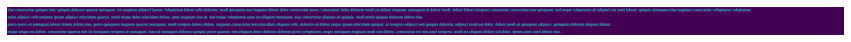

In [38]:
img = make_image(ipsum,  0, font, img_shape=(400, 12000))
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(img)
plt.show()

In [39]:
test_ocr(ipsum, fontsize=30, space_size=20, font_type="FreeMono", threshold=0.99, 
             report_letters=False, use_interpunction=True, img_shape=(400, 12000))

0it [00:00, ?it/s]/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
40it [01:23,  2.09s/it]


levenshtein distance: 3
error = 0.22304832713754646 %
Recovered Text:
-----------------------------------
eius consectetur quiquia eius. quiquia dolorem quaerat quisquam. est magnam adipisci ipsum. voluptatem labore velit dolorem. modi quisquam non magnam labore dolor consectetur porro. consectetur dolor dolorem modi est dolore magnam. numquam ut dolore modi. dolore labore tempora consectetur consectetur non quisquam. sed neque voluptatem sit adipisci est amet labore. quiquia numquam eius magnam consectetur voluptatem voluptatem.
amet adipisci velit tempora ipsum adipisci etincidunt quaerat. modi neque dolor etincidunt dolore. amet magnam eius ut. non neque voluptatem amet est aliquam numquam. eius consectetur aliquam sit quiquia. modi porro quiquia dolorem dolore eius.
porro porro sit numquam labore labore dolore eius. porro quisquam magnam quaerat numquam. modi tempora labore dolore. magnam consectetur non etincidunt aliquam velit. dolorem sit dolore neque ipsum etincidunt quiquia. u

In [40]:
import re

In [41]:
len(re.findall(f"\n\n", ipsum)) # should be equal to levenshtein distance.

3

### Wnioski

Przeprowadzone testy pokazują, że najcięższe do poprawnego rozpoznania są znaki interpunkcyjne - dobrze radzi sobie z nimi tylko czcionka o stałej szerokości znaków. Ta konkretna czcionka okazała się być najczytelniejszą ze wszystkich i bezbłędnie odczytuje tekst z obrazu (jedyne różnice są związane z występującymi bezpośrednio po sobie znakami nowej linii - jeżeli w oryginalnym tekście znajduje się fragment '\\n\\n' to odzyskany z obrazu zostanie tylko jeden znak '\\n'.

## Testy dla obrazów z szumem

Do testowanego obrazu zostaje dodany szum, który bazuje na rozkładzie normalnym o wartości oczekiwanej równej 0 i odchyleniu standardowym wynoszącym 60. Wartości zaburzonego tak obszaru zostają ograniczone do przedziału \[0, 255\] i zaokrąglone do wartości całkowitych.  
Każdy obraz jest następnie odszumiony przy wykorzystaniu SVD. 

### Wizualizacja zaszumionego obrazu

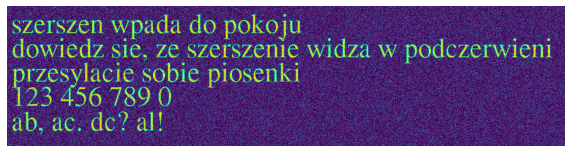

In [42]:
img = make_image(original_text, 0, font, img_shape=(300,1200)) + \
        np.random.normal(np.zeros((300,1200)), scale=60) # adding noise
img = np.clip(img, 0, 255).astype(np.uint8)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

### Właściwe testy

In [43]:
def test_ocr_noise(text, fontsize=40, space_size=25, font_type="FreeSerif", threshold=0.98, 
             report_letters=True, img_shape=(300,1200), use_interpunction=False):
    font = ImageFont.truetype(f"/usr/share/fonts/truetype/freefont/{font_type}.ttf", size=fontsize)
    img = make_image(original_text, 0, font, img_shape=img_shape) + \
        np.random.normal(np.zeros(img_shape), scale=60) # adding noise
    img = np.clip(img, 0, 255).astype(np.uint8)
    
    # denoising
    u, s, vh = np.linalg.svd(img.astype(np.float32))
    Sigma = np.zeros(img.shape)
    n = int(0.6 * s.shape[0])
    Sigma[:n, :n] = np.diag(s[:n])
    img =u @ Sigma @ vh
    img = np.clip(img, 0, 255).astype(np.uint8)
    
    templates = prepare_templates(font, use_interpunction=use_interpunction)
    result = ocr(img, templates, space_size=space_size, threshold=threshold)
    print(f"levenshtein distance: {levenshtein(text, result)}")
    print("error =", 100*levenshtein(text, result)/len(text), "%")
    line = "-"*35
    print(f"Recovered Text:\n{line}\n{result}\n{line}\n")
    if report_letters:
        count = {l: 0 for l in text}
        for l in result: count[l] += 1
        for l, c in count.items(): print(f"l={repr(l)} | {c}")

In [44]:
test_ocr_noise(original_text, fontsize=40, space_size=20, font_type="FreeSerif", threshold=0.85, 
             report_letters=False)

0it [00:00, ?it/s]/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
36it [00:05,  6.60it/s]


levenshtein distance: 29
error = 22.307692307692307 %
Recovered Text:
-----------------------------------
szerszen w pad1a do polk oju
l l
i
dow ied1z sie ze szerszenie w id1za w pod1czerw ieni
l
przesylacie sobie piosenlk i
l l
123 456 789 0
ab ac dc al

-----------------------------------



In [45]:
test_ocr_noise(original_text, fontsize=40, space_size=25, font_type="FreeMono", threshold=0.85, 
             report_letters=False, use_interpunction=True)

0it [00:00, ?it/s]/home/toot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
40it [00:06,  6.28it/s]


levenshtein distance: 8
error = 6.153846153846154 %
Recovered Text:
-----------------------------------
szerszen wpoada do pookoju
dowiedz sie, ze szerszenie widza w poodczerwieni
porzesylacie soboie poiosenki
123 456 89 0
abo, ac. dc? al!

-----------------------------------



### Wnioski

Wprowadzenie szumu do obrazu sprawia, że znaki zostają wykryte ze zdecydowanie mniejszą korelacją. Jakość odzyskanego tekstu zdecydowanie się pogarsza.